In [10]:
from __future__ import division
%matplotlib nbagg
import pandas as pd
import subprocess
import urllib2, os
import numpy as np
import matplotlib
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 14}
matplotlib.rc('font', **font)
import matplotlib.pyplot as plt
import json
from pprint import pprint
from netaddr import IPNetwork, IPAddress

PROCESSEDNAME = "validated_20150422"
#SAMPLENAME = "validate_20150422"
DATAPATH = "data/"
DATAPATH2 = "results/" + PROCESSEDNAME + "/"

SAMPLENAME = "categorize_censored_domains_20150424"
RESULTS = "results/" + SAMPLENAME + "/"
if not os.path.exists(RESULTS):
    os.makedirs(RESULTS)

# LOAD INFO

In [2]:
# main
df_sIP_subcat = pd.read_csv("data/Servers_IMC.txt")
df_all = pd.read_pickle(DATAPATH + "case_detected_all_20150412.pkl").reset_index()
df_all2 = pd.read_pickle(DATAPATH + "case_detected_all_20150422.pkl").reset_index()
df_full = pd.concat([df_all, df_all2])

In [3]:
# support
df_sIP_subcat = pd.read_csv("data/Servers_IMC.txt")
df_digs = pd.read_html(DATAPATH2 + 'updated_sIP_domain_to_check.html')[0].drop('Unnamed: 0', 1)
df_cdns= pd.read_html(DATAPATH2 + "potential_cdns_based_on_common_slash24.html")[0].drop('Unnamed: 0', 1)
df_censorship = pd.read_pickle(DATAPATH2 + 'censorship_ratio_slash24_global_us.pkl')

name_row = ['ASN', 'gIP', 'IPnet', 'country', 'agency', 'date', 'name']
df_ASN_gIP = pd.read_csv(DATAPATH2 + "all_asn_list.csv", skiprows=1, delimiter='|', skipinitialspace=True,
                      names=name_row,
                      converters={y : lambda x: x.strip() for y in name_row})

In [27]:
df_val = df_full.merge(df_ASN_gIP[['ASN', 'gIP']], on='gIP')
df_val['slash24'] = df_val['sIP'].apply(lambda x:x[:x.rfind(".")])
df_val = df_val[['sIP', 'slash24', 'domain', 'subcat', 'gIP', 'ASN', 'country', 'case', 'port']]
df_val.head()

,sIP,slash24,domain,subcat,gIP,ASN,country,case,port
0,171.67.215.200,171.67.215,stanford.edu,regional|reference,61.236.159.57,9394,CN,2,80
1,171.67.215.200,171.67.215,stanford.edu,regional|reference,61.236.159.57,9394,CN,2,80
2,162.159.244.215,162.159.244,sheknows.com,society,61.236.159.57,9394,CN,3,80
3,196.205.23.93,196.205.23,masrawy.com,world,61.236.159.57,9394,CN,2,80
4,38.101.236.62,38.101.236,dit-inc.us,circum,61.236.159.57,9394,CN,1,80


In [39]:
# helper functions
def get_raw_ratios(df_val):
    df_count = dfin.groupby(['sIP', 'domain', 'subcat', 'slash24',
                             'country', 'case'])['port'].count().unstack().fillna(0)
    df_count['tot'] = df_count.sum(axis=1)
    
    df_count['err'] = 0
    if (0 in df_count.columns):
        df_count['err']+= df_count[0]
    if (4 in df_count.columns):
        df_count['err']+= df_count[4]

    df_count['tot'] = df_count['tot'] - df_count['err']
    
    if 1 in df_count.columns:
        df_count['case1'] = df_count[1]/df_count['tot']
    if 2 in df_count.columns:
        df_count['case2'] = df_count[2]/df_count['tot']
    if 3 in df_count.columns:
        df_count['case3'] = df_count[3]/df_count['tot']
    return df_count

def get_raw_data(df_full, sIP, country=None):
    if country==None:
        df = df_full[(df_full['sIP']==sIP) ]
    else:
        df = df_full[(df_full['sIP']==sIP) & (df_full['country']==country) ]
    
    count_per_case = pd.DataFrame(df.groupby(['case'])['port'].count()).T
    get_ratios(count_per_case)
    
    count_per_case_gIP =  df.groupby([ 'gIP', 'case'])['port'].count().unstack().fillna(0)
    get_ratios(count_per_case_gIP)
    
    count_per_case_ASN =  df.groupby([ 'ASN', 'case'])['port'].count().unstack().fillna(0)
    get_ratios(count_per_case_ASN)
    
    censor = df_censorship[df_censorship['sIP']==sIP]
    return df, count_per_case, count_per_case_gIP, count_per_case_ASN, censor

In [38]:
# total censorship for each sIP in each country

def get_ratios(df_count):
    ''' assume df_count is indexed'''
    #df_count = dfin.groupby(['sIP', 'domain', 'subcat', 'slash24',
    #'country', 'case'])['port'].count().unstack().fillna(0)
    df_count['tot'] = df_count.sum(axis=1)
    
    df_count['err'] = 0
    if (0 in df_count.columns):
        df_count['err']+= df_count[0]
    if (4 in df_count.columns):
        df_count['err']+= df_count[4]

    df_count['tot'] = df_count['tot'] - df_count['err']
    
    if 1 in df_count.columns:
        df_count['case1'] = df_count[1]/df_count['tot']
    if 2 in df_count.columns:
        df_count['case2'] = df_count[2]/df_count['tot']
    if 3 in df_count.columns:
        df_count['case3'] = df_count[3]/df_count['tot']
    return df_count

def get_censorship_by_country_sIP(df_val, dimension='censorship'):
    censorship = df_val.groupby(['sIP', 'slash24', 'domain', 'subcat',
                                 'country', 'case'])['port'].count().unstack().fillna(0)
    get_ratios(censorship)
    global_censorship = df_val.groupby(['sIP', 'slash24', 'domain',
                                        'subcat', 'case'])['port'].count().unstack().fillna(0)
    get_ratios(global_censorship)
    if dimension == 'censorship':
        censor_country = (1 - censorship['case2']).unstack()
        censor_global = (1 - global_censorship['case2'])
    else:
        # dimension can be err, tot, case1, case2, case3, 1, 2, 3, 4, 0 apart from censorship
        censor_country = censorship[dimension].unstack()
        censor_global = global_censorship[dimension]
        
    censor_country['global'] = censor_global
    #censor_country= censor_country.reset_index()
    return censor_country

In [40]:
def getCDF(data):
    xdata = np.sort(data)
    ydata = [i/len(xdata) for i in range(len(xdata))]
    return xdata, ydata

# Separate results for US/SE
- why US and SE: cdf of behavior

In [41]:
censorship2 = get_censorship_by_country_sIP(df_val)[['US','SE', 'JP', 'CN', 'IR', 'IN', 'TR']]

<IPython.core.display.Javascript object>


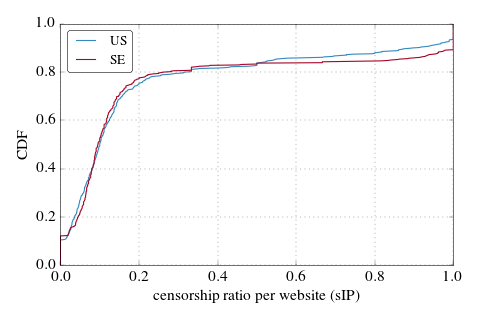

In [44]:
fig1, ax1 = plt.subplots(1,1, figsize=(6,4))

x,y = getCDF( list( censorship2['US'] ) )
ax1.plot(x,y, label='US')
x,y = getCDF( list( censorship2['SE'] ) )
ax1.plot(x,y, label='SE')
'''
x,y = getCDF( list( censorship2['JP'] ) )
ax1.plot(x,y, label='JP')
x,y = getCDF( list( censorship2['CN'] ) )
ax1.plot(x,y, label='CN')
x,y = getCDF( list( censorship2['IR'] ) )
ax1.plot(x,y, label='IR')
x,y = getCDF( list( censorship2['IN'] ) )
ax1.plot(x,y, label='IN')
x,y = getCDF( list( censorship2['TR'] ) )
ax1.plot(x,y, label='TR')
'''
ax1.set_xlabel("censorship ratio per website (sIP)")
ax1.set_ylabel("CDF")
ax1.grid(1)
ax1.legend(loc='best', fontsize=12)
fig1.tight_layout()
fig1.show()

# Types US/SE censorship expected
- previous plot shows a CDF knee at censorship = 0.2, basically those 21% or so of the sIPs must be cloudflare.
- type1: highly censored in US/SE
- type2: US blocked, SE unblocked
- type3: US unblocked, SE blocked
- type4: uncensored (static IPs?)

## Categorizing bad sIPs

In [110]:
df_temp = df_digs[df_digs['error']==1]
df_temp2 = df_temp[df_temp['domain']!='torDir']
bad_sIP1 = list( df_temp2[df_temp2['html']!=1]['sIP'] )
print len(bad_sIP1)

bad_sIP2 = list( df_censorship[df_censorship['us'] > 0.80]['sIP'] )
print len(bad_sIP2)

bad_sIP3 = list( df_cdns['sIP'] )
print len(bad_sIP3)

bad_sIP_list = bad_sIP1 + bad_sIP2 + bad_sIP3
print len(bad_sIP_list)

88
62
73
223


In [116]:
print len(bad_sIP1 + bad_sIP2)
THRESH = 0.2

150


In [ ]:
type1 = censorship[ (censorship['US'] > THRESH) & (censorship['SE'] > THRESH) ].reset_index()
print len( type1 )
print len( type1[ type1['sIP'].isin(bad_sIP1 + bad_sIP2) ] )

In [109]:
type2 = censorship[ (censorship['US'] > THRESH) & (censorship['SE'] <= THRESH) ].reset_index()
print len( type2 )
print len( type2[ type2['sIP'].isin(bad_sIP1 + bad_sIP2) ] )

NameError: name 'THRESH' is not defined

In [109]:
type3 = censorship[ (censorship['US'] < THRESH) & (censorship['SE'] > THRESH) ].reset_index()
print len( type3 )
print len( type3[ type3['sIP'].isin(bad_sIP1 + bad_sIP2) ] )

34
8


In [110]:
type4 = censorship[ (censorship['US'] < THRESH) & (censorship['SE'] <= THRESH) ].reset_index()
print len( type4 )
print len( type4[ type4['sIP'].isin(bad_sIP1 + bad_sIP2) ] )

374
61


In [111]:
type1

country,sIP,slash24,domain,subcat,US,SE,US-tot,SE-tot
0,104.16.5.13,104.16.5,change.org,society,0.989011,1.000000,91,63
1,104.16.7.118,104.16.7,petmd.com,health,1.000000,1.000000,99,51
2,104.20.12.28,104.20.12,studentdoctor.net,health,1.000000,1.000000,103,32
3,104.20.28.30,104.20.28,bungie.net,kids_and_teens|games,0.989130,1.000000,92,53
4,104.20.28.34,104.20.28,tunnelbear.com,vpn,1.000000,1.000000,89,50
5,104.20.5.196,104.20.5,furaffinity.net,adult,1.000000,1.000000,66,12
6,104.28.7.85,104.28.7,indiansexstories.net,adult,1.000000,1.000000,89,45
7,107.20.154.40,107.20.154,strava.com,sports,0.870968,0.975610,62,41
8,107.20.157.190,107.20.157,suicidegirls.com,adult,0.939024,0.902439,82,41
9,108.162.201.77,108.162.201,theknot.com,society,1.000000,1.000000,54,57


In [170]:
sIP_US = df_full[ (df_full['sIP']=='107.20.154.40') & (df_full['country']=='US')]
bycase = sIP_US.groupby(['gIP','case'])['port'].count().unstack()[[1,2,3]]
case1 = bycase[bycase[1]>0]
case2 = bycase[bycase[2]>0]
case3 = bycase[bycase[3]>0]

print len(bycase)
print len(case1)
print len(case2)
print len(case3)

62
47
8
4


In [171]:
bycase[ (bycase[2]>0) & (bycase[1]>0) ]

case,1,2,3
gIP,,,


In [182]:
sIP_gIP_case = df_full[ df_full['country'] == 'US' ].groupby(['sIP', 'domain', 'gIP', 'country', 'case'])['port'].count().unstack()

In [183]:
sIP_gIP_case[(sIP_gIP_case[1] > 0) & (sIP_gIP_case[2] > 0)]

case                                                         0  1  2   3   4
sIP             domain              gIP            country                  
1.209.122.23    riseup.net          76.14.151.18   US      NaN  1  2 NaN NaN
103.6.182.20    agoda.com           72.31.193.135  US      NaN  1  1 NaN NaN
                                    72.31.195.41   US      NaN  1  1 NaN NaN
                                    97.69.193.57   US      NaN  1  1 NaN NaN
109.201.152.100 planetsuzy.org      69.150.151.253 US        1  1  1 NaN NaN
                                    98.137.31.172  US      NaN  1  1 NaN NaN
109.71.160.200  livejasmin.com      74.202.46.178  US      NaN  1  1 NaN NaN
121.241.247.61  thehindu.com        69.139.176.213 US      NaN  1  1 NaN NaN
129.228.25.181  nick.com            69.150.151.253 US      NaN  1  1 NaN NaN
146.232.21.22   sun.ac.za           69.139.194.102 US      NaN  1  1 NaN NaN
163.211.251.1   jal.co.jp           72.31.2.155    US      NaN  1  1   1 NaN
166.78.40.244   pcgamer.com         69.150.151.253 US        1  1  1 NaN NaN
174.129.236.153 slate.com           8.28.152.10    US      NaN  1  1 NaN NaN
184.28.188.154  foxnews.com         98.137.31.172  US      NaN  1  1   1 NaN
192.211.12.20   zillow.com          69.150.151.253 US      NaN  1  1   1 NaN
192.81.240.190  rockstargames.com   72.11.90.20    US      NaN  1  1 NaN NaN
195.234.240.212 dailymail.co.uk     98.137.31.172  US      NaN  1  1 NaN NaN
195.62.67.210   stardoll.com        69.139.219.50  US      NaN  1  1 NaN NaN
195.93.246.56   ar.rian.ru          69.66.8.49     US      NaN  1  1 NaN NaN
196.205.23.93   masrawy.com         69.139.168.26  US      NaN  1  1 NaN NaN
196.22.143.67   cricket.co.za       97.69.193.57   US      NaN  1  1 NaN NaN
199.15.160.100  deviantart.com      76.76.1.94     US      NaN  1  1 NaN NaN
199.83.132.152  css-tricks.com      69.150.151.253 US      NaN  1  1   1 NaN
206.220.43.92   mtv.com             76.161.216.26  US      NaN  1  1 NaN NaN
207.246.147.179 streamate.com       69.150.151.253 US        1  1  1 NaN NaN
208.85.40.50    pandora.com         69.139.200.142 US        1  1  2 NaN NaN
212.100.239.219 copyscape.com       70.99.147.14   US      NaN  1  1 NaN NaN
213.136.89.190  praag.co.za         98.137.31.172  US      NaN  2  1 NaN NaN
216.248.207.17  pch.com             98.137.31.172  US      NaN  1  1 NaN NaN
216.250.115.137 republikein.com.na  98.138.97.31   US      NaN  1  1 NaN NaN
216.250.171.190 psychologytoday.com 69.150.151.253 US      NaN  1  1 NaN NaN
23.23.208.240   minecraft.net       98.137.31.172  US      NaN  1  1 NaN NaN
23.6.108.215    jcpenney.com        76.14.151.18   US      NaN  1  2 NaN NaN
31.192.116.24   youporn.com         70.99.147.14   US      NaN  1  1 NaN NaN
50.16.229.208   biblegateway.com    74.202.46.178  US      NaN  1  1 NaN NaN
54.225.210.86   dorkly.com          72.31.193.135  US      NaN  1  1 NaN NaN
68.169.206.169  grubhub.com         98.137.31.172  US      NaN  1  1 NaN NaN
69.55.61.163    y8.com              69.150.151.253 US      NaN  1  1 NaN NaN
                                    69.172.236.90  US      NaN  1  1 NaN NaN
                                    72.243.61.250  US      NaN  1  1 NaN NaN
                                    72.34.244.74   US      NaN  1  2 NaN NaN
                                    76.161.79.26   US      NaN  1  1 NaN NaN
97.74.104.218   godaddy.com         76.161.216.26  US      NaN  1  1 NaN NaN
                                    8.28.152.10    US      NaN  1  1 NaN NaN

In [184]:
print len(sIP_gIP_case)
print len(sIP_gIP_case[(sIP_gIP_case[1] > 0) & (sIP_gIP_case[2] > 0)])
print len(sIP_gIP_case[(sIP_gIP_case[3] > 0) & (sIP_gIP_case[2] > 0)])
print len(sIP_gIP_case[(sIP_gIP_case[1] > 0) & (sIP_gIP_case[3] > 0)])
print len(sIP_gIP_case[(sIP_gIP_case[1] > 0) & (sIP_gIP_case[2] > 0) & (sIP_gIP_case[3] > 0)])

32736
44
261
14
4


In [151]:
for z in range(10):
    x = df_full[ (df_full['sIP']=='107.20.154.40') & (df_full['country']=='US')][['diff_list', 'domain', 'gIP','case']].iloc[z]
    print x['gIP'], x['case'], x['diff_list']
print diff_list

96.43.134.178 2 [None, None, 26, 4, 14, 23, 9, 21, 36, 10, 26, 14, 16, 15, 16, 17, 17, 18, 31, 8, 12, 16, 7, 10, 11, 10, 9, 10, 46, 6, 3, 4, 17, 10, 0, 7, 20, 14, 31, 8, 14, 5, 16, 8, 15, 8, 23, 12, 45, 15, 8, 46, 31, 13, 7, 11, 23, 8, 50, 3, 52, 22, 29, 58, 46, 39, 25, 81, 71, 38, 25, 34, 49, 33, 26, 26, 44, 41, 64, 31, 41, 28, 50, 39, 33, 28, 39, 35, 72, 36, 31, 38, 36, 36, 34, 56, 42, 35, 56, 99, 34, 25, 32, 28, 36, 35, 74, 32, 72, 24, 32, 23, 35, 34, 41, 31, 34, 35, 65, 27]
97.69.194.167 2 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 16, 15, 15, 18, 18, 17, 16, 14, 17, 16, 18, 19, 17, 17, 18, 20, 18, 16, 17, 18, 19, 18, 14, 17, 18, 15, 14, 16, 17, 19, 18, 18, 16, 18, 17, 14, 17, 21, 20, 20, 23, 17, 16, 18, 23, 19, 18, 20, 15, 19, 15, 13, 15, 16, 19, 18, 17, 19]
67.51.37.122 2 [None, None, None, 0, 0, 0, 3, 1, 0, 0, 0, 3, 0, 0, 0, 0, 3, 0, 0

## Prelim plot of ALL DATA (no rejects)

In [103]:
censor_country = get_censorship_by_country_sIP(df_val)

# list of interesting countries to plot and explore
COUNTRY_LIST = ['US', 'SE', 'JP', 'FR', 'CN', 'IR', 'IN', 'SA', 'global']

<IPython.core.display.Javascript object>


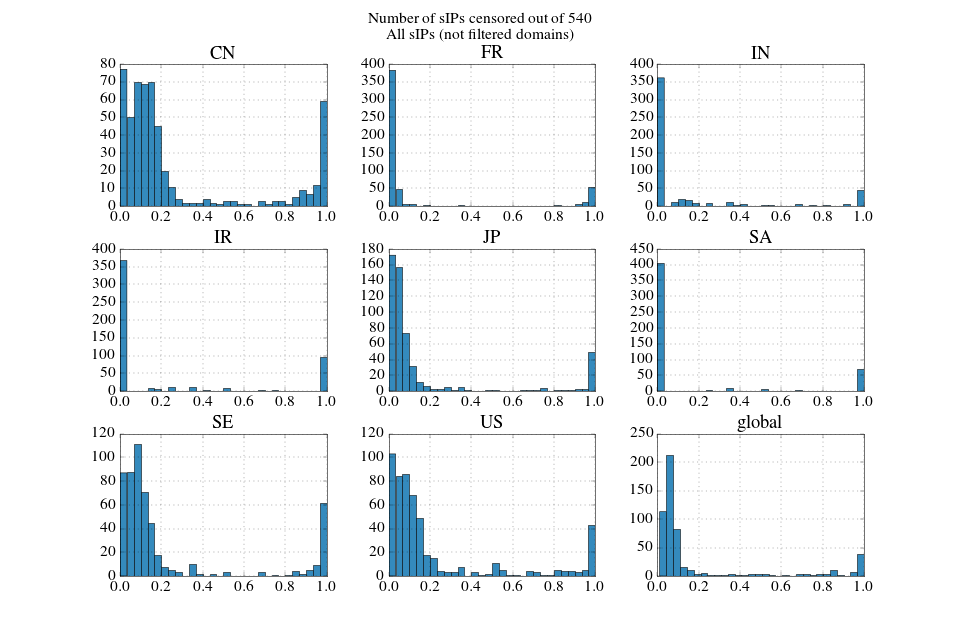

In [104]:
# Plot Raw data no filtering
censor_country[ COUNTRY_LIST ].hist(bins=30, figsize=(12,8))
plt.suptitle("Number of sIPs censored out of {0}\n\
All sIPs (not filtered domains)".format(len(censor_country)))
plt.savefig(RESULTS + "hist_censorship_no_filter")
plt.show()


## Categorizing bad sIPs

### bad_sIP1: those with dig error (IP not found) or html error (domain not found in page)

<IPython.core.display.Javascript object>


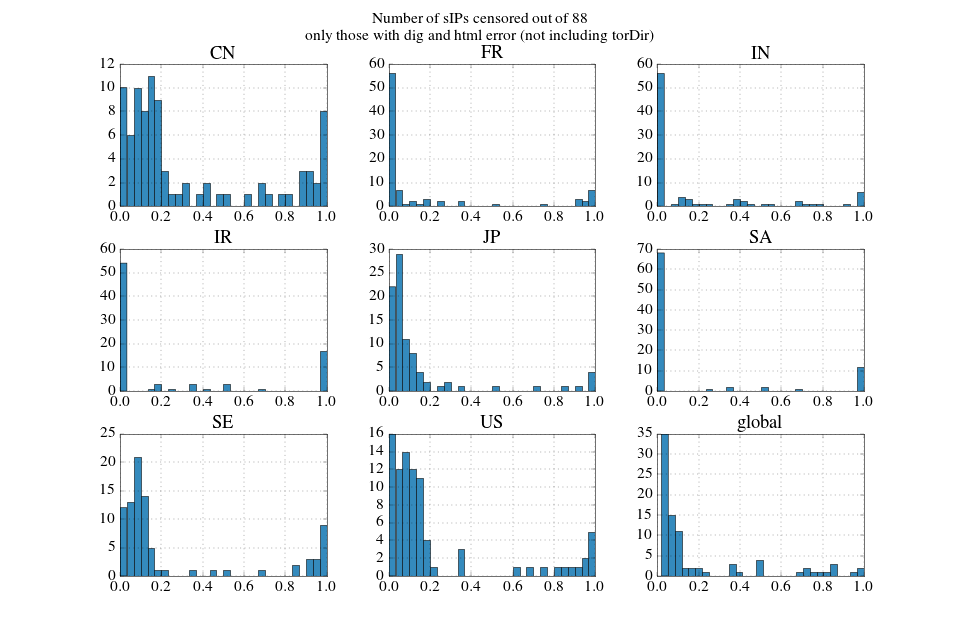

In [134]:
# Now filter the bad_sIP1
filter1 = censor_country.reset_index()
filter1[ filter1['sIP'].isin(bad_sIP1) ][
   COUNTRY_LIST ].hist(bins=30, figsize=(12,8))
plt.suptitle("Number of sIPs censored out of {0}\n\
only those with dig and html error (not including torDir)".format(len(bad_sIP1)))
plt.savefig(RESULTS + "hist_censorship_bad_sIP1")
plt.show()

<IPython.core.display.Javascript object>


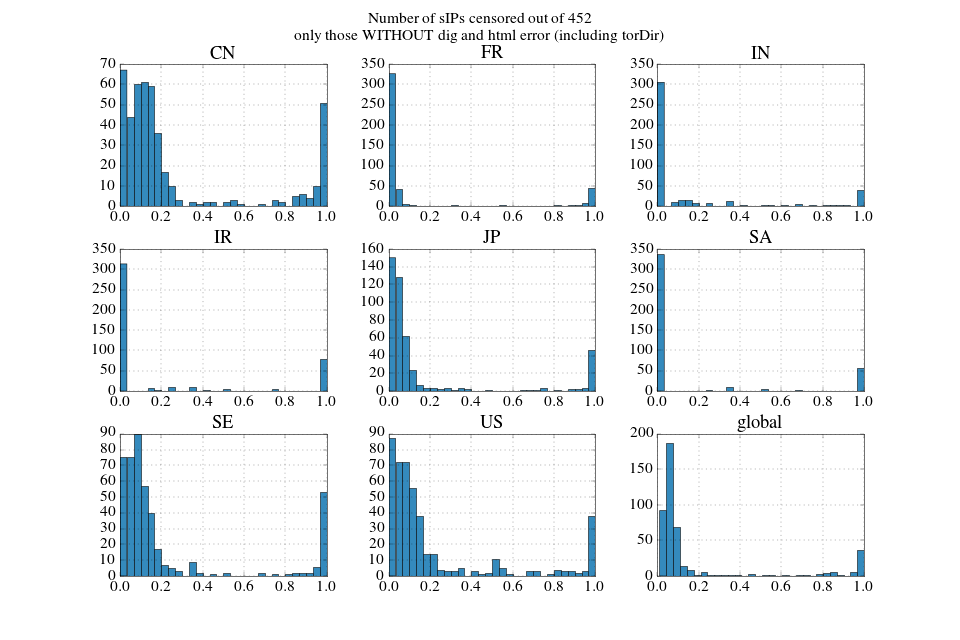

In [135]:
# without bad_sIP1
filter1 = censor_country.reset_index()
filter1[~filter1['sIP'].isin(bad_sIP1) ][
    COUNTRY_LIST ].hist(bins=30, figsize=(12,8))
plt.suptitle("Number of sIPs censored out of {0}\n\
only those WITHOUT dig and html error (including torDir)".format(len(censor_country) - len(bad_sIP1)))
plt.savefig(RESULTS + "hist_censorship_filter_bad_sIP1")
plt.show()

### Conclusion: bad_sIP1
- doesn't seem like an awesome filter
- low change in plots

### bad_sIP2: those with us censorship > 80% but still in alexa top 1000

<IPython.core.display.Javascript object>


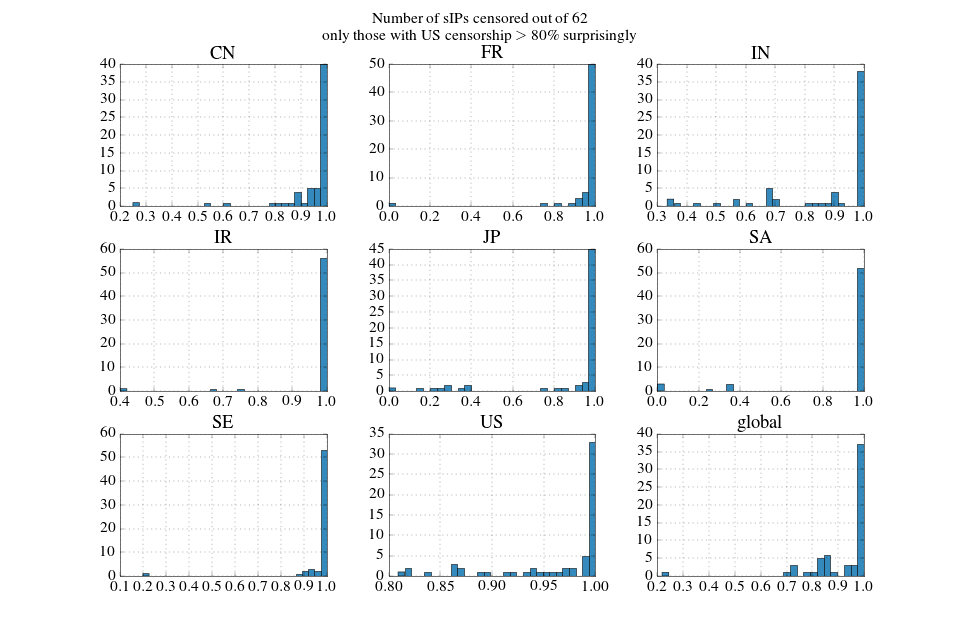

In [136]:
# Now filter the bad_sIP2
filter2 = censor_country.reset_index()
filter2[ filter2['sIP'].isin(bad_sIP2) ][
    COUNTRY_LIST ].hist(bins=30, figsize=(12,8))
plt.suptitle("Number of sIPs censored out of {0}\n\
only those with US censorship $>$ 80\% surprisingly".format(len(bad_sIP2)))
plt.savefig(RESULTS + "hist_censorship_bad_sIP2")
plt.show()

<IPython.core.display.Javascript object>


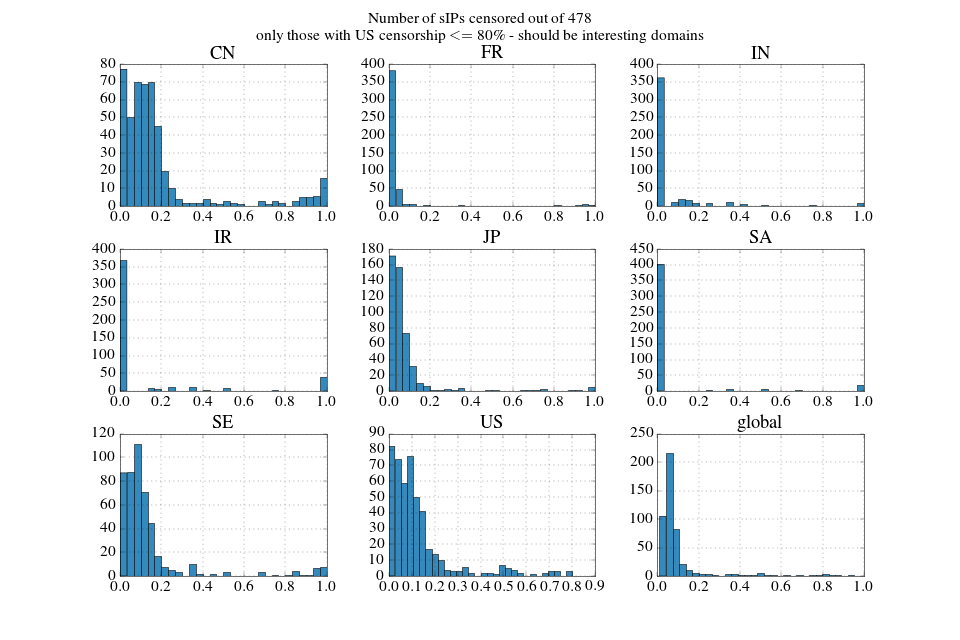

In [137]:
# without bad_sIP2
filter2 = censor_country.reset_index()
filter2[~filter2['sIP'].isin(bad_sIP2) ][
    COUNTRY_LIST ].hist(bins=30, figsize=(12,8))
plt.suptitle("Number of sIPs censored out of {0}\n\
only those with US censorship $<=$ 80\% - should be interesting domains".format(len(censor_country) - len(bad_sIP2)))
plt.savefig(RESULTS + "hist_censorship_filter_bad_sIP2")
plt.show()

### Conclusion: bad_sIP2
- got 40-60 domains in every country
- impacts the US, but somehow plots for SE and JP still look similar to without filtering
- probably not such a good filter?

### bad_sIP3: those suspected as CDN because slash24 has more than 1 domains

<IPython.core.display.Javascript object>


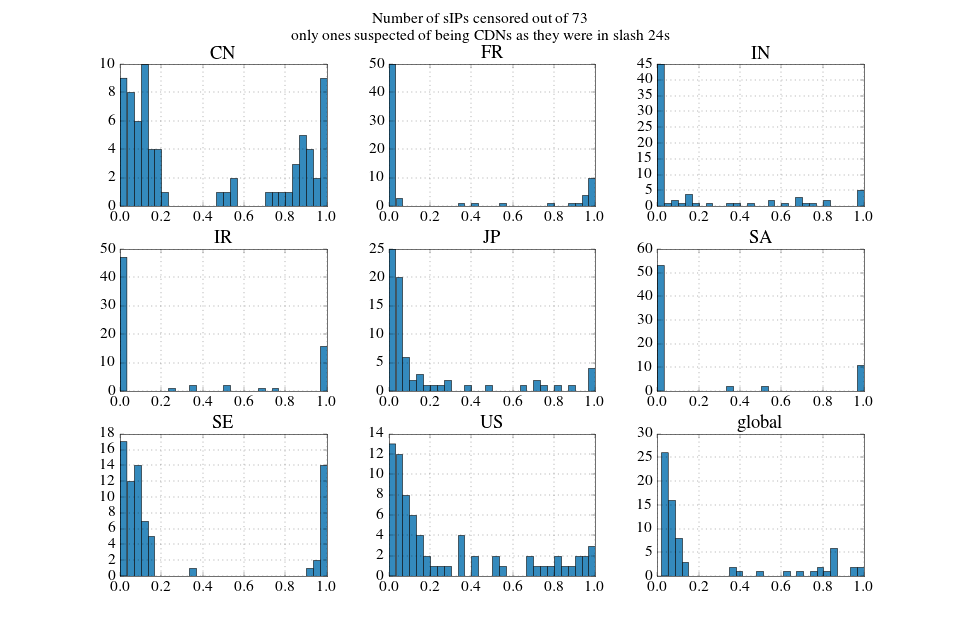

In [141]:
# Now filter the bad_sIP2
filter3 = censor_country.reset_index()
filter3[ filter3['sIP'].isin(bad_sIP3) ][
    COUNTRY_LIST ].hist(bins=30, figsize=(12,8))
plt.suptitle("Number of sIPs censored out of {0}\n\
only ones suspected of being CDNs as they were in slash 24s".format(len(bad_sIP3)))
plt.savefig(RESULTS + "hist_censorship_bad_sIP3")
plt.show()

<IPython.core.display.Javascript object>


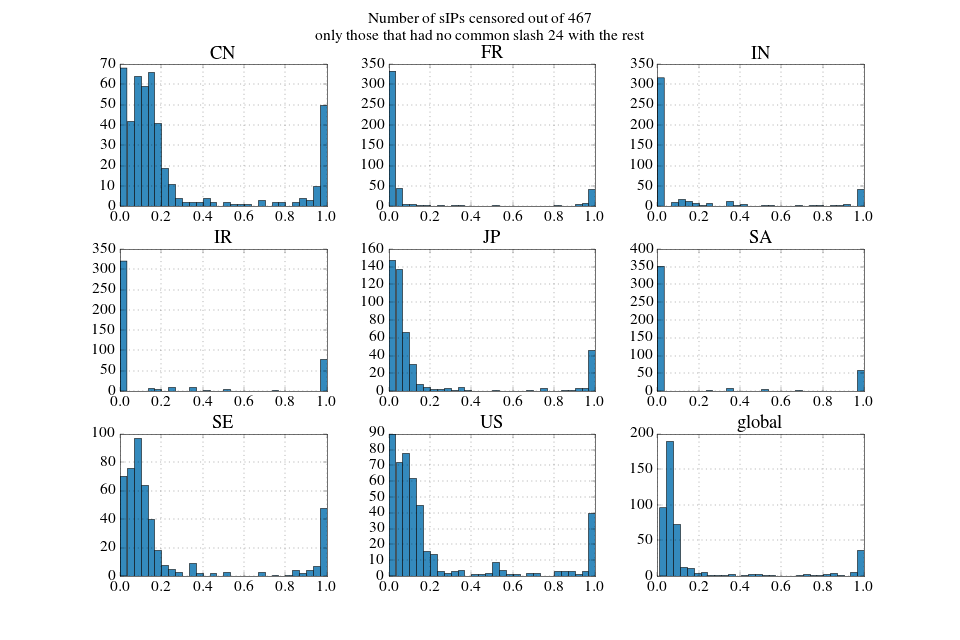

In [142]:
# without bad_sIP2
filter3 = censor_country.reset_index()
filter3[~filter3['sIP'].isin(bad_sIP3) ][
    COUNTRY_LIST ].hist(bins=30, figsize=(12,8))
plt.suptitle("Number of sIPs censored out of {0}\n\
only those that had no common slash 24 with the rest".format(len(censor_country) - len(bad_sIP3)))
plt.savefig(RESULTS + "hist_censorship_filter_bad_sIP3")
plt.show()

### Conclusion: bad_sIP3
- got 30-50 domains in every country
- impact on final plots doesn't seem to high
- probably not such a good filter?

### bad_sIP_list: aggressive culmination of all of the above filters (probably not disjoint)

<IPython.core.display.Javascript object>


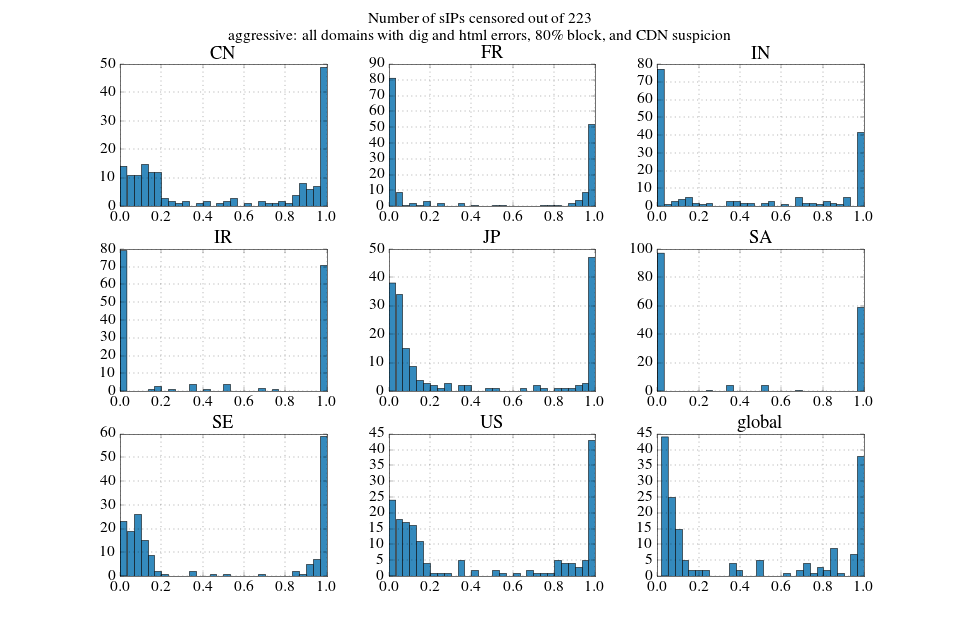

In [145]:
# Now filter the bad_sIP_list
filter_agg = censor_country.reset_index()
filter_agg[ filter_agg['sIP'].isin(bad_sIP_list) ][
    COUNTRY_LIST ].hist(bins=30, figsize=(12,8))
plt.suptitle("Number of sIPs censored out of {0}\n\
aggressive: all domains with dig and html errors, 80\% block, and CDN suspicion".format(len(bad_sIP_list)))
plt.savefig(RESULTS + "hist_censorship_bad_sIP_list")
plt.show()

<IPython.core.display.Javascript object>


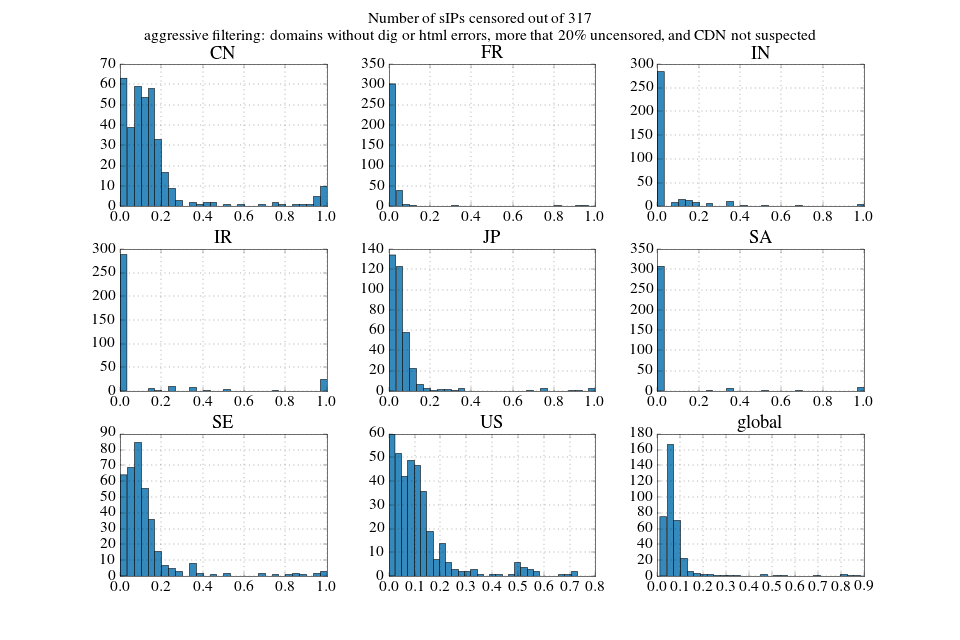

In [146]:
# without bad_sIP_list
filter_agg = censor_country.reset_index()
filter_agg[~filter_agg['sIP'].isin(bad_sIP_list) ][
    COUNTRY_LIST ].hist(bins=30, figsize=(12,8))
plt.suptitle("Number of sIPs censored out of {0}\n\
aggressive filtering: domains without dig or html errors, more that 20\% uncensored, and CDN not suspected".format(len(censor_country) - len(bad_sIP_list)))
plt.savefig(RESULTS + "hist_censorship_filter_bad_sIP_list")
plt.show()

### Conclusion: bad_sIP_list
- I cant even.

# PCA common censorship patterns and k-means the domains

In [150]:
#from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
#from mpl_toolkits.mplot3d import Axes3D
#from mpl_toolkits.mplot3d import proj3d
#tsne = TSNE(n_components=2, random_state=0)
pca = PCA(n_components=2)

In [158]:
temp = censor_country.reset_index().set_index('domain').fillna(0)
del temp['sIP'], temp['slash24'], temp['subcat']

<IPython.core.display.Javascript object>


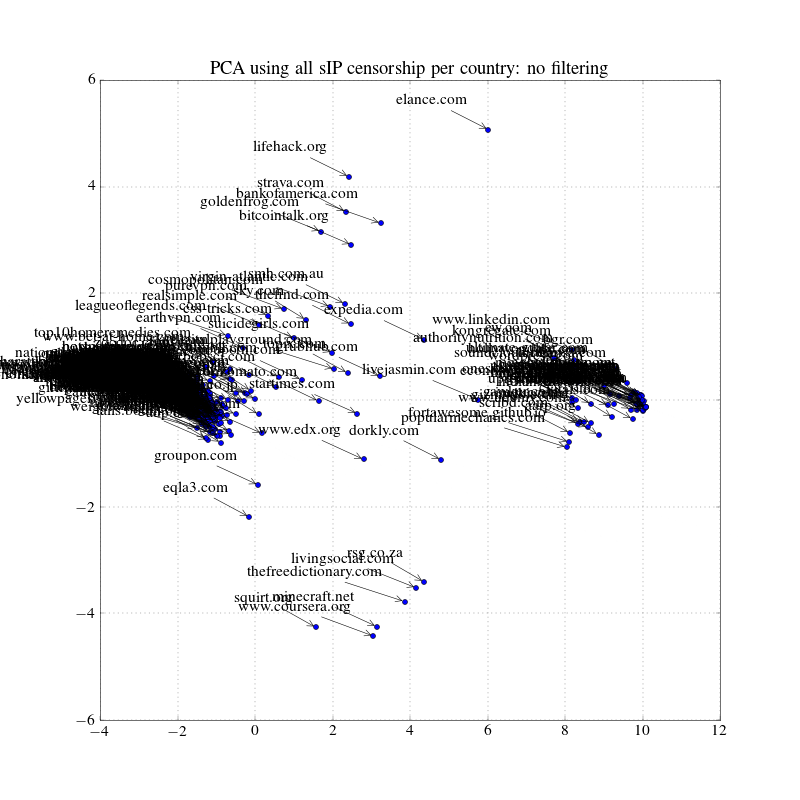

In [159]:
df4 = pd.DataFrame(pca.fit_transform(temp.as_matrix())).set_index(temp.index)
fig2, ax2 = plt.subplots(1,1, figsize=(10,10))
ax2.scatter(df4[0], df4[1])
for label, x, y in zip(df4.index, df4[0], df4[1]):
    ax2.annotate(
        label, 
        xy = (x, y), xytext = (-20, 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        #bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
ax2.grid(1)
ax2.set_title("PCA  using all sIP censorship per country: no filtering")
fig2.savefig(RESULTS + "pca_sIPs_countries_censorship_all")
fig2.show()

### Aggressive Filtering

In [165]:
filter_agg = censor_country.reset_index()
temp = filter_agg[~filter_agg['sIP'].isin(bad_sIP_list) ].set_index('domain').fillna(0)
del temp['sIP'], temp['slash24'], temp['subcat']

<IPython.core.display.Javascript object>


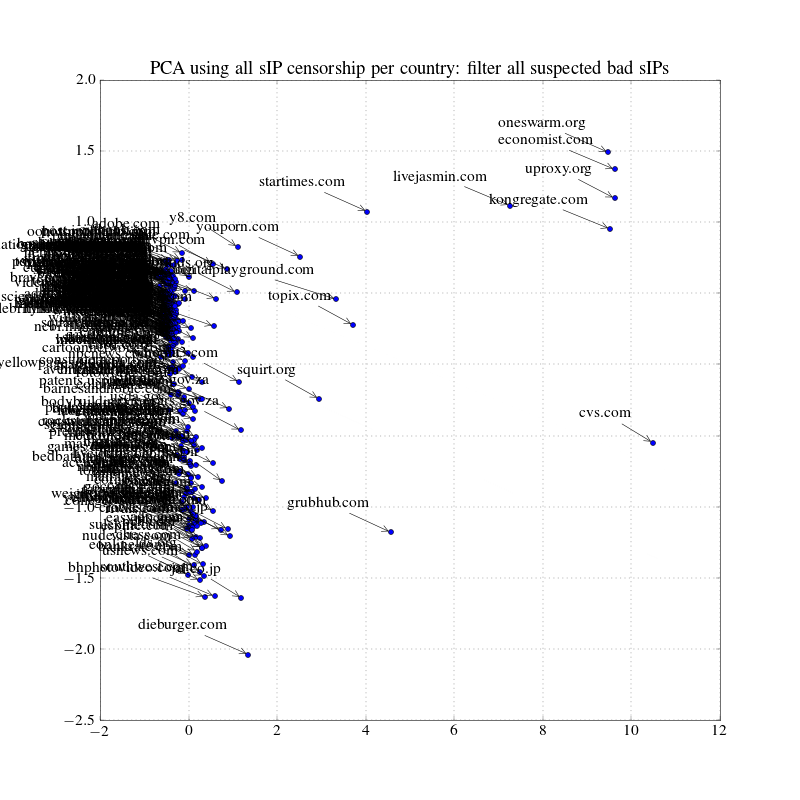

In [166]:
df4 = pd.DataFrame(pca.fit_transform(temp.as_matrix())).set_index(temp.index)
fig2, ax2 = plt.subplots(1,1, figsize=(10,10))
ax2.scatter(df4[0], df4[1])
for label, x, y in zip(df4.index, df4[0], df4[1]):
    ax2.annotate(
        label, 
        xy = (x, y), xytext = (-20, 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        #bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
ax2.grid(1)
ax2.set_title("PCA  using all sIP censorship per country: filter all suspected bad sIPs")
fig2.savefig(RESULTS + "pca_sIPs_countries_censorship_filter_bad_sIP_aggressive")
fig2.show()

### Conclusions on filtered PCA
- huge change in clustering: no idea why
- try country clusters based on domains?

# PCA on .t

In [168]:
temp = censor_country.reset_index().set_index('domain').fillna(0)
del temp['sIP'], temp['slash24'], temp['subcat']
temp2 = temp.T

<IPython.core.display.Javascript object>


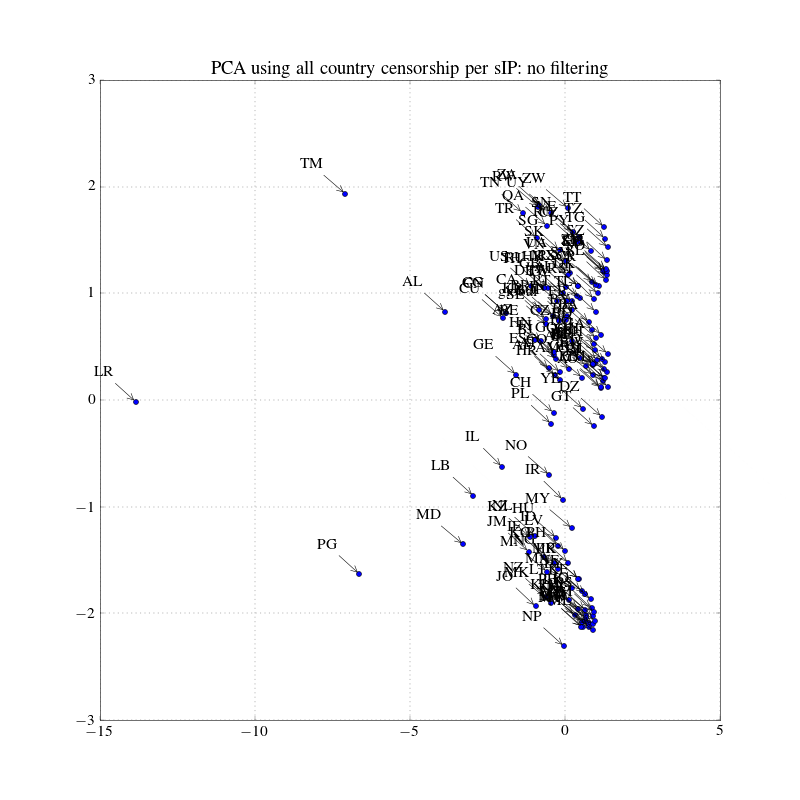

In [169]:
df4 = pd.DataFrame(pca.fit_transform(temp2.as_matrix())).set_index(temp2.index)
fig2, ax2 = plt.subplots(1,1, figsize=(10,10))
ax2.scatter(df4[0], df4[1])
for label, x, y in zip(df4.index, df4[0], df4[1]):
    ax2.annotate(
        label, 
        xy = (x, y), xytext = (-20, 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        #bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
ax2.grid(1)
ax2.set_title("PCA  using all country censorship per sIP: no filtering")
fig2.savefig(RESULTS + "pca_countries_sIP_censorship_all")
fig2.show()

In [171]:
filter_agg = censor_country.reset_index()
temp = filter_agg[~filter_agg['sIP'].isin(bad_sIP_list) ].set_index('domain').fillna(0)
del temp['sIP'], temp['slash24'], temp['subcat']
temp2 = temp.T

<IPython.core.display.Javascript object>


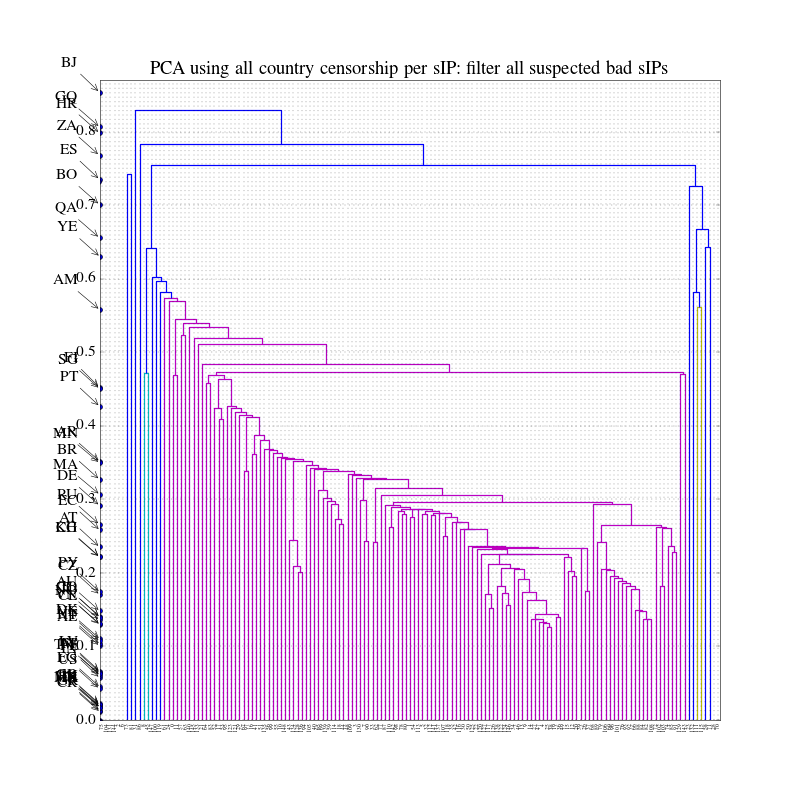

In [173]:
df4 = pd.DataFrame(pca.fit_transform(temp2.as_matrix())).set_index(temp2.index)
fig2, ax2 = plt.subplots(1,1, figsize=(10,10))
ax2.scatter(df4[0], df4[1])
for label, x, y in zip(df4.index, df4[0], df4[1]):
    ax2.annotate(
        label, 
        xy = (x, y), xytext = (-20, 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        #bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
ax2.grid(1)
ax2.set_title("PCA  using all country censorship per sIP: filter all suspected bad sIPs")
fig2.savefig(RESULTS + "pca_countries_sIP_censorship_filter_bad_sIP_aggressive")
fig2.show()

## Raw work on the country_censor data

In [52]:
tested_censored = df_digs.merge(censor_country.reset_index()[['sIP', 'US', 'JP', 'SE', 'CN', 'global']], on='sIP')
tested_censored.head()

,domain,error,resolved,sIP,isCDN,httpcode,html,errcode,revDNS,US,JP,SE,CN,global
0,uproxy.org,0,"[216.239.38.21, 216.239.32.21, 216.239.34.21, ...",216.239.38.21,0,-1,-1,404,[any-in-2615.1e100.net.],0.563218,1.000000,0.736842,0.875000,0.806375
1,biblegateway.com,0,[50.16.229.208],50.16.229.208,0,-1,-1,403,[ec2-50-16-229-208.compute-1.amazonaws.com.],0.029412,0.018182,0.088235,0.052632,0.038462
2,express-vpn.com,0,[104.130.112.72],104.130.112.72,0,-1,-1,403,[],0.087719,0.035088,0.098039,0.111111,0.047826
3,mercola.com,0,[199.66.166.210],199.66.166.210,0,-1,-1,404,[],0.111111,0.019608,0.090909,0.172414,0.051345
4,sars.gov.za,0,[196.38.114.178],196.38.114.178,0,-1,-1,404,[],0.136364,0.125000,0.156250,0.200000,0.208955


### EVERYWHERE FULLY CENSORED (ignoring errors)

In [54]:
# completely censored in US and EVERYWHERE ELSE IN THE WORLD => must be cloudflare to be in top alexa!
full_censor = censor_country[censor_country['US']==1]
dev = (full_censor.max(axis=1) - full_censor.min(axis=1))
print "Websites on cloudflare (probably): REMOVE"
sip_list1 = list( full_censor[dev==0].reset_index()['sIP'] )
full_censor[dev==0]

Websites on cloudflare (probably): REMOVE


,,,country,AE,AF,AL,AM,AO,AR,AT,AU,AZ,BA,...,US,UY,UZ,VE,VN,YE,ZA,ZM,ZW,global
sIP,slash24,domain,subcat,,,,,,,,,,,,,,,,,,,,,
104.16.7.118,104.16.7,petmd.com,health,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,NaN,1,1,1,1
104.20.5.196,104.20.5,furaffinity.net,adult,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,NaN,1,1,1,1
141.101.118.148,141.101.118,myegy.com,world,1,1,NaN,1,1,1,1,1,1,1,...,1,1,1,1,1,NaN,1,1,1,1
198.41.185.7,198.41.185,get.ironsocket.com,vpn,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,NaN,1,1,1,1
23.235.33.217,23.235.33,vimeo.com,computers,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,NaN,1,1,1,1
23.235.37.64,23.235.37,jalopnik.com,recreation,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,NaN,1,1,1,1
54.85.98.80,54.85.98,lifehack.org,home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,...,1,1,1,1,1,NaN,1,1,1,1


In [56]:
# check these out in detail: error codes
tested_censored [ tested_censored['sIP'].isin(sip_list1) ]

,domain,error,resolved,sIP,isCDN,httpcode,html,errcode,revDNS,US,JP,SE,CN,global
28,myegy.com,0,"[141.101.118.148, 141.101.118.149]",141.101.118.148,0,-1,-1,403,[],1,1,1,1,1
61,furaffinity.net,0,"[104.20.3.196, 104.20.4.196, 104.20.5.196, 104...",104.20.5.196,0,-1,-1,403,[],1,1,1,1,1
94,vimeo.com,0,"[23.235.37.217, 104.156.81.217, 23.235.33.217,...",23.235.33.217,0,-1,-1,500,[],1,1,1,1,1
128,lifehack.org,1,[54.175.12.151],54.85.98.80,0,-1,-1,-1,[ec2-54-85-98-80.compute-1.amazonaws.com.],1,1,1,1,1
301,get.ironsocket.com,0,"[198.41.185.7, 198.41.184.7]",198.41.185.7,0,-1,-1,403,[],1,1,1,1,1
308,petmd.com,0,"[104.16.11.118, 104.16.10.118, 104.16.8.118, 1...",104.16.7.118,0,-1,-1,403,[],1,1,1,1,1
504,jalopnik.com,0,"[104.156.81.64, 104.156.85.64, 23.235.33.64, 2...",23.235.37.64,0,-1,-1,500,[],1,1,1,1,1


In [51]:
full_censor = censor_country[censor_country['US']==1]
dev = (full_censor.max(axis=1) - full_censor.min(axis=1))

Websites on cloudflare (probably): REMOVE


,,,country,AE,AF,AL,AM,AO,AR,AT,AU,AZ,BA,...,US,UY,UZ,VE,VN,YE,ZA,ZM,ZW,global
sIP,slash24,domain,subcat,,,,,,,,,,,,,,,,,,,,,
104.16.7.118,104.16.7,petmd.com,health,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,NaN,1,1,1,1
104.20.5.196,104.20.5,furaffinity.net,adult,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,NaN,1,1,1,1
141.101.118.148,141.101.118,myegy.com,world,1,1,NaN,1,1,1,1,1,1,1,...,1,1,1,1,1,NaN,1,1,1,1
198.41.185.7,198.41.185,get.ironsocket.com,vpn,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,NaN,1,1,1,1
23.235.33.217,23.235.33,vimeo.com,computers,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,NaN,1,1,1,1
23.235.37.64,23.235.37,jalopnik.com,recreation,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,NaN,1,1,1,1
54.85.98.80,54.85.98,lifehack.org,home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,...,1,1,1,1,1,NaN,1,1,1,1


### Manual testing 1:
- all except on are cloudflare (403 err). The one is a 404

### US FULLY CENSORED BUT NO WHERE ELSE

In [63]:
sip_list2 = list(dev[dev>0].reset_index()['sIP'])
dev

sIP              slash24      domain                 subcat                 
104.16.7.118     104.16.7     petmd.com              health                     0.000000
104.20.12.28     104.20.12    studentdoctor.net      health                     0.500000
104.20.28.34     104.20.28    tunnelbear.com         vpn                        0.333333
104.20.5.196     104.20.5     furaffinity.net        adult                      0.000000
104.28.7.85      104.28.7     indiansexstories.net   adult                      0.200000
108.162.201.77   108.162.201  theknot.com            society                    0.166667
136.1.107.78     136.1.107    ford.com               recreation|business        1.000000
141.101.113.126  141.101.113  planetminecraft.com    games                      0.333333
141.101.115.236  141.101.115  elance.com             business                   0.333333
141.101.118.148  141.101.118  myegy.com              world                      0.000000
141.101.121.193  141.101.121  btc

In [82]:
# completely censored in US but not everywhere?
check_country = full_censor[dev>0.0]

# if the minimum entry for any interesting US censored website is not 1, only then keep it
for column in check_country.columns:
    if check_country[column].min() >= 0.8:
        del check_country[column]

check_country[['global', 'SE', 'CN', 'JP', 'FR']]

,,,country,global,SE,CN,JP,FR
sIP,slash24,domain,subcat,,,,,
104.20.12.28,104.20.12,studentdoctor.net,health,0.997930,1.0,1.000000,1.000000,1.000000
104.20.28.34,104.20.28,tunnelbear.com,vpn,0.996071,1.0,0.982143,1.000000,1.000000
104.28.7.85,104.28.7,indiansexstories.net,adult,0.998946,1.0,1.000000,1.000000,1.000000
108.162.201.77,108.162.201,theknot.com,society,0.998741,1.0,1.000000,1.000000,1.000000
136.1.107.78,136.1.107,ford.com,recreation|business,0.989899,1.0,0.966667,1.000000,1.000000
141.101.113.126,141.101.113,planetminecraft.com,games,0.999093,1.0,1.000000,1.000000,1.000000
141.101.115.236,141.101.115,elance.com,business,0.996000,1.0,1.000000,1.000000,1.000000
141.101.121.193,141.101.121,btc-e.com,science,0.998771,1.0,1.000000,1.000000,1.000000
141.101.127.195,141.101.127,jeddahbikers.com,world,0.997630,1.0,1.000000,1.000000,1.000000


In [75]:
tested_censored [ tested_censored['sIP'].isin(sip_list2) ].sort(columns='global', ascending=False)

,domain,error,resolved,sIP,isCDN,httpcode,html,errcode,revDNS,US,JP,SE,CN,global
452,planetminecraft.com,0,"[190.93.241.126, 190.93.242.126, 141.101.123.1...",141.101.113.126,0,-1,-1,403,[],1,1.000000,1.0,1.000000,0.999093
223,indiansexstories.net,0,"[104.28.6.85, 104.28.7.85]",104.28.7.85,0,-1,-1,403,[],1,1.000000,1.0,1.000000,0.998946
75,blockchain.info,0,"[190.93.243.195, 141.101.112.196]",190.93.243.195,0,-1,-1,403,[],1,1.000000,1.0,1.000000,0.998940
441,btc-e.com,0,"[141.101.121.193, 141.101.121.194]",141.101.121.193,0,-1,-1,403,[],1,1.000000,1.0,1.000000,0.998771
401,theknot.com,0,"[108.162.201.77, 108.162.202.77]",108.162.201.77,0,-1,-1,403,[],1,1.000000,1.0,1.000000,0.998741
464,nordvpn.com,0,"[162.159.241.236, 162.159.240.236]",162.159.241.236,0,-1,-1,403,[],1,1.000000,1.0,1.000000,0.998720
481,minecraftforum.net,0,"[141.101.114.118, 141.101.115.118, 190.93.245....",190.93.245.117,0,-1,-1,403,[],1,1.000000,1.0,1.000000,0.998624
51,clevelandclinic.org,0,[192.35.79.223],192.35.79.223,0,-1,-1,403,"[;;, Truncated,, retrying, in, TCP, mode., www...",1,0.983333,1.0,1.000000,0.998440
163,capitalone.com,1,"[208.80.48.175, 208.80.50.175]",208.80.48.112,0,200,1,200,[],1,1.000000,1.0,1.000000,0.998195
348,studentdoctor.net,0,"[104.20.13.28, 104.20.12.28]",104.20.12.28,0,-1,-1,403,[],1,1.000000,1.0,1.000000,0.997930


### Manual testing 2
- working domains with ipaddr in browser:
 - fedex.com [204.135.13.155] iss reacheable. It appears censored but has errcode 200 in http test.
 - businessweek.com [69.191.252.14] works easily -- why does it show censorship full then? Globally 97% but http works and no problem with dig, code 200. Just like fedex.
 - virginatlantic.com [80.82.135.10] also works, somehow missed this entry in df_digs
 - skycreative.com [90.216.128.5] also works. it seems to be on a CDN but can be reached by IP at the moment. Weirdly, global censorship for this is 0.99
 
- all on cloudflare or some other protection (access denied):
 - tumblr.com [66.6.43.30] is code 200 but reaches a "nothing here" page. Only US is full censorship (1) on tumblr, others are actually very very low (0.2). Weird?
 - capitalone.com [208.80.48.112] also works has code 200. But globally 98% censored?
 - gizmodo.com [23.235.44.129] says no domain and has err code 500, not reachable from US but why only from japan?
 - top list is all 403 Cloudflare. Not sure how they got at least some response.
 - icicibank.com is 403, but not cloudflare.
 - fortawesome.github.io [23.235.47.133] do reach host website but the page doesn't exist. fortawesome is 404



### US MOSTLY CENSORED (95%) BUT NO WHERE ELSE

In [113]:
full_censor = censor_country[ (censor_country['US']<1) & ( censor_country['US']>0.95)  ]
dev = (full_censor.max(axis=1) - full_censor.min(axis=1))
sip_list3 = list(dev[dev>0].reset_index()['sIP'])
print len(dev)
# sort it on the differen
dev.sort()
dev

12


sIP              slash24      domain                  subcat              
104.20.28.30     104.20.28    bungie.net              kids_and_teens|games    0.010870
198.41.209.136   198.41.209   reddit.com              news|games|world        0.022222
190.93.241.98    190.93.241   goodsearch.com          society                 0.166667
190.93.247.118   190.93.247   mmo-champion.com        games                   0.166667
190.93.244.102   190.93.244   curse.com               games                   0.333333
129.35.201.80    129.35.201   lufthansa.com           recreation              0.500000
209.67.181.70    209.67.181   rakuten.com             shopping                0.666667
104.16.5.13      104.16.5     change.org              society                 1.000000
171.159.228.150  171.159.228  bankofamerica.com       regional|business       1.000000
199.91.50.125    199.91.50    livingsocial.com        shopping                1.000000
209.160.58.87    209.160.58   thefreedictionary.com   r

In [99]:
# 95% censored in US but weirdness elsewhere
check_country = full_censor[dev>0.0]

# if the minimum entry for any interesting US censored website is not 1, only then keep it
for column in check_country.columns:
    if check_country[column].min() >= 0.8:
        del check_country[column]

check_country

,,,country,AE,AF,AL,AM,AO,AR,AT,AU,AZ,BA,...,UA,UG,UY,UZ,VE,VN,ZA,ZM,ZW,global
sIP,slash24,domain,subcat,,,,,,,,,,,,,,,,,,,,,
104.16.5.13,104.16.5,change.org,society,1.00,1,1,1,1,1.000000,1.00,1.000000,1,1,...,1.000000,1,1,1,1,1.000000,1.000000,1,1.000000,0.994048
104.20.28.30,104.20.28,bungie.net,kids_and_teens|games,1.00,1,1,1,1,1.000000,NaN,1.000000,1,1,...,1.000000,1,1,1,1,1.000000,1.000000,1,1.000000,0.998918
129.35.201.80,129.35.201,lufthansa.com,recreation,1.00,1,NaN,1,1,1.000000,1.00,1.000000,1,1,...,1.000000,1,1,1,1,1.000000,1.000000,1,1.000000,0.983204
171.159.228.150,171.159.228,bankofamerica.com,regional|business,NaN,NaN,NaN,NaN,NaN,1.000000,1.00,0.500000,NaN,1,...,1.000000,1,1,1,1,1.000000,0.714286,1,1.000000,0.885343
190.93.241.98,190.93.241,goodsearch.com,society,1.00,1,1,1,1,0.833333,NaN,1.000000,1,1,...,1.000000,1,1,1,1,1.000000,1.000000,1,1.000000,0.996809
190.93.244.102,190.93.244,curse.com,games,1.00,1,NaN,1,1,1.000000,1.00,1.000000,1,1,...,1.000000,1,1,1,1,1.000000,1.000000,1,1.000000,0.997967
190.93.247.118,190.93.247,mmo-champion.com,games,1.00,1,1,1,1,1.000000,1.00,1.000000,1,1,...,1.000000,1,1,1,1,1.000000,1.000000,1,1.000000,0.996994
198.41.209.136,198.41.209,reddit.com,news|games|world,1.00,1,1,1,1,1.000000,1.00,NaN,1,1,...,1.000000,1,NaN,1,1,1.000000,1.000000,1,1.000000,0.997852
199.91.50.125,199.91.50,livingsocial.com,shopping,0.00,0,1,0,0,0.750000,0.75,0.666667,0,0,...,0.571429,0,0,0,0,0.500000,0.000000,0,0.000000,0.728878


In [104]:
df_digs[df_digs['sIP'].isin(sip_list3)]

,domain,error,resolved,sIP,isCDN,httpcode,html,errcode,revDNS
76,thefreedictionary.com,1,[209.40.98.58],209.160.58.87,0,200,0,200,[ns1.farlex.com.]
92,goodsearch.com,0,"[190.93.243.98, 190.93.242.98, 141.101.123.98,...",190.93.241.98,0,-1,-1,403,[]
93,bungie.net,0,"[104.20.29.30, 104.20.28.30]",104.20.28.30,0,-1,-1,403,[]
108,bankofamerica.com,0,"[171.159.228.150, 171.161.148.150]",171.159.228.150,0,200,1,200,[]
120,curse.com,0,"[190.93.244.102, 190.93.246.101, 190.93.247.10...",190.93.244.102,0,-1,-1,403,[]
127,authoritynutrition.com,0,[72.21.91.8],72.21.91.8,0,-1,-1,404,[]
175,livingsocial.com,0,[199.91.50.125],199.91.50.125,0,-1,-1,403,[]
182,change.org,0,"[104.16.5.13, 104.16.4.13]",104.16.5.13,0,-1,-1,403,[]
235,lufthansa.com,0,[129.35.201.80],129.35.201.80,0,-1,-1,-1,[]
303,rakuten.com,0,[209.67.181.70],209.67.181.70,0,-1,1,200,[www.rakuten.com.]


### Manual Testing 3
- bungie.net, reddit.com, goodsearch.com, mmo-champion.com, curse.com are all protected by cloudflare
- lufthansa.com [129.35.201.80] was in the dig list, and got no response for any of the digs tests, had global and US censorship 0.95
- rakuten.com [209.67.181.70] also works easily with IPaddress
- change.org [] was cloudflare
- bankofamera.com [171.159.228.150] works easily
- livingsocial is 403, thefreedictionary.com [209.160.58.87] gives a weird blank page
- autoritynutrition.com [72.21.91.8] is 404

### US MOSTLY CENSORED (70%) BUT NO WHERE ELSE

In [128]:
full_censor = censor_country[ (censor_country['US']<=0.95) & ( censor_country['US']>0.7)  ]
dev = (full_censor.max(axis=1) - full_censor.min(axis=1))
sip_list4 = list(dev[dev>0].reset_index()['sIP'])
print len(dev)
# sort it on the differen
dev.sort()
# 1 implies that diff was 1 bete
#dev
full_censor.sort(columns='global')

24


,,,country,AE,AF,AL,AM,AO,AR,AT,AU,AZ,BA,...,US,UY,UZ,VE,VN,YE,ZA,ZM,ZW,global
sIP,slash24,domain,subcat,,,,,,,,,,,,,,,,,,,,,
199.83.132.152,199.83.132,css-tricks.com,kids_and_teens|computers,0.000000,1,0.000000,1,0.666667,0.500000,0.000000,0.000000,1.000000,0.666667,...,0.744186,0.000000,0.333333,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.356749
199.83.132.16,199.83.132,purevpn.com,vpn,0.000000,0,0.000000,0,0.000000,0.000000,0.250000,0.500000,0.000000,0.000000,...,0.728571,0.666667,0.666667,0.500000,1.000000,NaN,0.600000,0.666667,0.000000,0.381773
199.83.128.142,199.83.128,earthvpn.com,vpn,0.000000,NaN,NaN,NaN,NaN,0.333333,1.000000,0.400000,NaN,1.000000,...,0.728571,0.000000,0.000000,0.000000,0.400000,NaN,0.000000,0.000000,0.000000,0.471642
174.129.236.153,174.129.236,slate.com,society|regional,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,NaN,NaN,...,0.712766,NaN,NaN,NaN,NaN,NaN,0.714286,NaN,NaN,0.515326
107.20.157.190,107.20.157,suicidegirls.com,adult,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000,0.571429,NaN,NaN,...,0.939024,0.333333,0.333333,0.333333,1.000000,NaN,0.333333,0.333333,0.333333,0.696894
196.35.152.185,196.35.152,rsg.co.za,world,0.333333,0,0.500000,0,0.000000,0.250000,0.714286,0.000000,0.333333,0.250000,...,0.914894,0.000000,0.000000,0.000000,0.000000,NaN,0.333333,0.000000,0.000000,0.717949
107.20.154.40,107.20.154,strava.com,sports,0.000000,NaN,0.000000,NaN,NaN,0.000000,0.333333,0.500000,NaN,1.000000,...,0.870968,1.000000,1.000000,1.000000,1.000000,NaN,1.000000,1.000000,1.000000,0.766607
23.235.40.129,23.235.40,gawker.com,arts|regional,1.000000,1,NaN,1,1.000000,1.000000,0.333333,1.000000,NaN,1.000000,...,0.800000,1.000000,1.000000,1.000000,0.000000,NaN,0.750000,1.000000,0.666667,0.784123
108.174.10.10,108.174.10,www.linkedin.com,world|computers,1.000000,1,1.000000,NaN,1.000000,1.000000,1.000000,0.600000,1.000000,1.000000,...,0.838710,1.000000,1.000000,1.000000,0.750000,NaN,1.000000,1.000000,1.000000,0.793103


In [123]:
dev.reset_index().merge(df_digs, on=['sIP', 'domain'], how='left')

,sIP,slash24,domain,subcat,0,error,resolved,isCDN,httpcode,html,errcode,revDNS
0,199.27.76.185,199.27.76,cosmopolitan.com,society|regional,0.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,23.235.46.193,23.235.46,imgur.com,computers,1.000000,0,[23.235.46.193],0,-1,-1,500,[]
2,23.235.44.194,23.235.44,wikia.com,computers,1.000000,1,[199.27.76.194],0,-1,-1,500,[]
3,23.235.44.175,23.235.44,www.udemy.com,reference,1.000000,1,"[c.global-ssl.fastly.net., 199.27.76.175]",1,-1,-1,500,[]
4,23.235.40.129,23.235.40,gawker.com,arts|regional,1.000000,1,"[23.235.33.129, 23.235.37.129, 104.156.81.129,...",0,-1,-1,500,[]
5,23.235.39.184,23.235.39,self.com,health,1.000000,0,"[23.235.39.184, 199.27.76.184]",0,-1,-1,500,[]
6,204.79.197.200,204.79.197,bing.com,world|computers|reference,1.000000,0,[204.79.197.200],0,200,1,200,[a-0001.a-msedge.net.]
7,204.69.244.10,204.69.244,vitals.com,health,1.000000,0,[204.69.244.10],0,-1,-1,401,[]
8,199.83.132.16,199.83.132,purevpn.com,vpn,1.000000,0,"[199.83.134.16, 199.83.132.16]",0,-1,-1,503,[199.83.132.16.ip.incapdns.net.]
9,199.83.132.152,199.83.132,css-tricks.com,kids_and_teens|computers,1.000000,1,[216.70.88.177],0,-1,-1,503,[199.83.132.152.ip.incapdns.net.]


In [142]:
censor_country[['US', 'JP', 'SE', 'global']].sort(columns='global', ascending=False)

,,,country,US,JP,SE,global
sIP,slash24,domain,subcat,,,,
104.20.5.196,104.20.5,furaffinity.net,adult,1.000000,1.000000,1.000000,1.000000
141.101.118.148,141.101.118,myegy.com,world,1.000000,1.000000,1.000000,1.000000
23.235.37.64,23.235.37,jalopnik.com,recreation,1.000000,1.000000,1.000000,1.000000
23.235.33.217,23.235.33,vimeo.com,computers,1.000000,1.000000,1.000000,1.000000
104.16.7.118,104.16.7,petmd.com,health,1.000000,1.000000,1.000000,1.000000
198.41.185.7,198.41.185,get.ironsocket.com,vpn,1.000000,1.000000,1.000000,1.000000
54.85.98.80,54.85.98,lifehack.org,home,1.000000,1.000000,1.000000,1.000000
141.101.113.126,141.101.113,planetminecraft.com,games,1.000000,1.000000,1.000000,0.999093
104.28.7.85,104.28.7,indiansexstories.net,adult,1.000000,1.000000,1.000000,0.998946


### Manual Testing 4
- cosmopolitan.com, imgur.com, wikia.com, udemy.com, gawker.com, self.com all have 500 err response.
- bing.com [204.79.197.200] is reachable, no dig error, and 200 code. 
- vitals.com [204.69.244.10] err code 503, or 401 - unauthorized access

In [170]:
cf = df_digs.merge(censor_country[['global', 'US', 'SE', 'JP', 'CN']].reset_index(), on=['sIP', 'domain'], how='left').sort(columns='global', ascending=False)
cf.to_html(RESULTS + 'countries_censorship_ratio.html')

In [168]:
df_count[(df_count['country']=='JP') & (df_count['sIP']=="152.111.200.209")]

case,sIP,domain,subcat,country,0,1,2,3,4,tot,err,case1,case2,case3
10587,152.111.200.209,dieburger.com,world,JP,20,1,90,1,0,92,20,0.01087,0.978261,0.01087


<IPython.core.display.Javascript object>


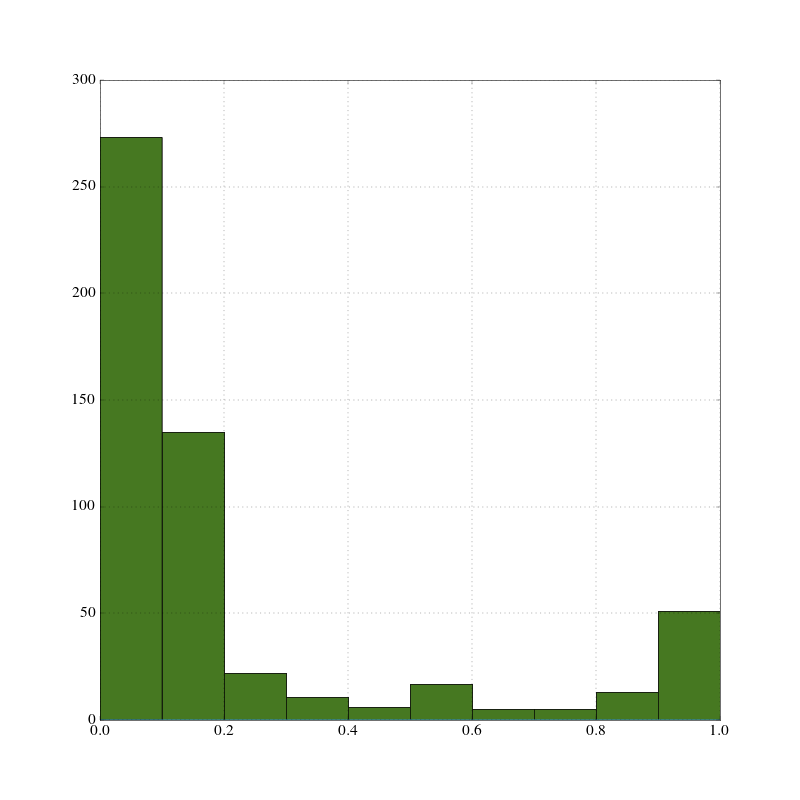

In [86]:
fig1, ax1 = plt.subplots(1, 1, figsize=(10,10) )

x,y = getCDF(list( censor_country['US'] ))
ax1.plot(x,y, label='US')

ax1.grid(1)
fig1.show()

In [58]:
#df_sIP_ASN = df_full.groupby(['sIP', 'domain', 'ASN', 'country', 'case'])['port'].count().fillna(0).reset_index().rename(columns={'port':'count'})
df_digs2 = df_digs[['domain', 'sIP', 'error', 'errcode', 'html', 'revDNS']]

# fist filter: home page is reacheable on http and contains the domain name
print len (df_digs2[ (df_digs2['html']==1) ])
print len (df_digs2)

# in these html reachable domains, are there CDNs?
html_reacheable_cdns = df_cdns[ df_cdns['sIP'].isin( df_digs2[ (df_digs2['html']==1) ]['sIP'] ) ]
print len (html_reacheable_cdns)
html_reacheable_cdns

219
505
15


,domain_x,sIP,total,global,us,us-tot,se,se-tot,jp,slash24,domain_y
2,ancestry.com,66.43.22.183,368,0.062500,0.000000,3,0.000000,4,0.000000,66.43.22,2
3,findagrave.com,66.43.22.135,368,0.046196,0.000000,1,0.000000,4,0.000000,66.43.22,2
15,bhg.com,198.186.175.108,821,0.037759,0.057143,70,0.023810,42,0.011236,198.186.175,2
20,google.com,74.125.28.101,858,0.118881,0.114943,87,0.023256,43,0.116279,74.125.28,13
22,mail.google.com,74.125.28.83,743,0.087483,0.080000,50,0.063830,47,0.014493,74.125.28,13
23,maps.google.com,74.125.28.138,332,0.069277,0.500000,2,0.000000,4,0.000000,74.125.28,13
24,play.google.com,74.125.28.139,346,0.060694,0.000000,3,0.000000,2,0.000000,74.125.28,13
27,www.google.com,74.125.28.104,769,0.083225,0.042254,71,0.061224,49,0.027778,74.125.28,13
28,www.youtube.com,74.125.28.136,678,0.123894,0.029412,34,0.117647,17,0.062500,74.125.28,13
29,youtube.com,74.125.28.190,701,0.095578,0.255319,47,0.019608,51,0.035714,74.125.28,13


In [9]:
corr_mat = censor_country.corr()

<IPython.core.display.Javascript object>


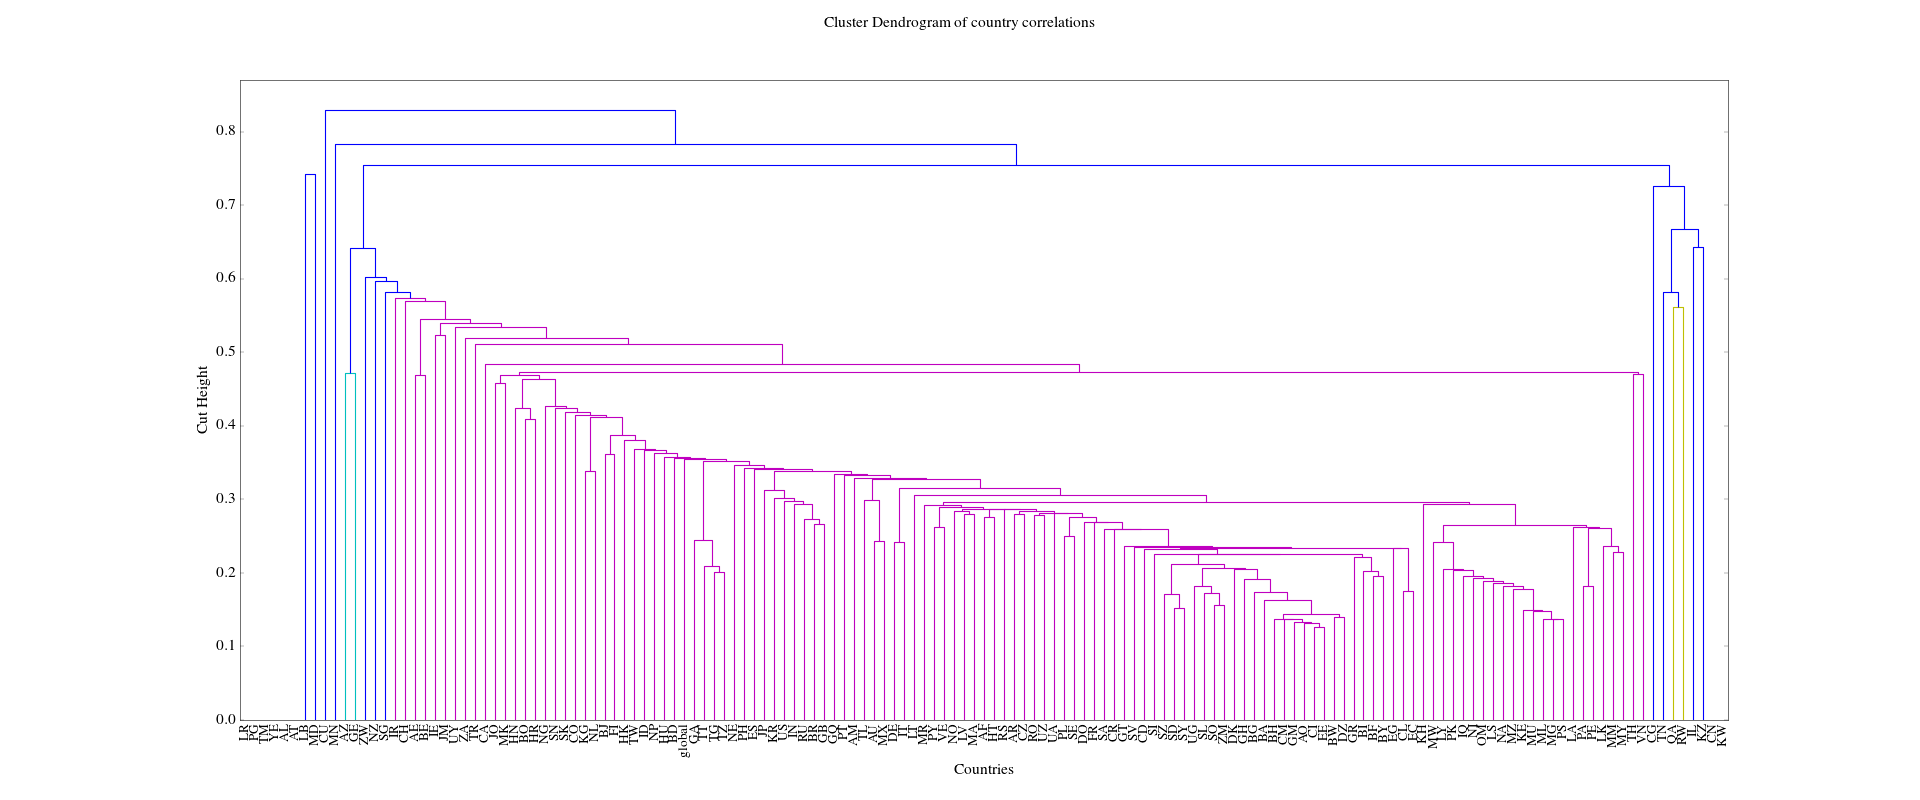

In [10]:
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram

#Z=linkage(X, 'single', 'correlation')

fig1, ax1 = plt.subplots(1,1, figsize=(24,10))

Z=linkage(corr_mat, 'single')

R = dendrogram(Z)

ax1.set_xlabel('Countries')
ax1.set_ylabel('Cut Height')

labels = [item.get_text() for item in ax1.get_xticklabels()]
country_labels = [corr_mat.index[int(i)] for i in labels]

ax1.set_xticklabels(country_labels, fontsize = 12)
fig1.suptitle('Cluster Dendrogram of country correlations', fontweight='bold', fontsize=14);

fig1.savefig("hierarchical_clustering_country_correlation_all")

In [22]:
corr_mat = censor_country.T.corr()

fig1, ax1 = plt.subplots(1,1, figsize=(30,10))

# single clusters together the closest countries first
Z=linkage(corr_mat, 'single')

R = dendrogram(Z)

ax1.set_xlabel('Countries')
ax1.set_ylabel('Cut Height')

labels = [item.get_text() for item in ax1.get_xticklabels()]
country_labels = [corr_mat.index[int(i)] for i in labels]

ax1.set_xticklabels(country_labels, fontsize = 8)
fig1.suptitle('Cluster Dendrogram of domain correlations', fontweight='bold', fontsize=14);

fig1.savefig("hierarchical_clustering_domain_correlation_filtered_all")

<IPython.core.display.Javascript object>

RuntimeError: LaTeX was not able to process the following string:
"('157.166.226.25', '157.166.226', 'cnn.com', 'science|kids_and_teens|arts|health|news')"
Here is the full report generated by LaTeX: 

This is pdfTeX, Version 3.1415926-2.5-1.40.14 (TeX Live 2013/Debian)
 restricted \write18 enabled.
entering extended mode
(./f855d3f0f3fd73d70e8dec829c4b357a.tex
LaTeX2e <2011/06/27>
Babel <3.9h> and hyphenation patterns for 78 languages loaded.
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2007/10/19 v1.4h Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texlive/texmf-dist/tex/latex/psnfss/mathptmx.sty)
(/usr/share/texlive/texmf-dist/tex/latex/psnfss/courier.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.def))
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/share/texlive/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

)
No file f855d3f0f3fd73d70e8dec829c4b357a.aux.
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1cmr.fd)
(/usr/share/texlive/texmf-dist/tex/latex/psnfss/ot1ptm.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.12 ..., '157.166.226', 'cnn.com', 'science|kids_
                                                  and_teens|arts|health|news')}

(/usr/share/texlive/texmf-dist/tex/latex/psnfss/ot1ztmcm.fd)
(/usr/share/texlive/texmf-dist/tex/latex/psnfss/omlztmcm.fd)
(/usr/share/texlive/texmf-dist/tex/latex/psnfss/omsztmcm.fd)
(/usr/share/texlive/texmf-dist/tex/latex/psnfss/omxztmcm.fd)
! Extra }, or forgotten $.
l.12 ...science|kids_and_teens|arts|health|news')}
                                                  
! Missing $ inserted.
<inserted text> 
                $
l.13 \end{document}
                   
[1] (./f855d3f0f3fd73d70e8dec829c4b357a.aux) )
(\end occurred inside a group at level 1)

### simple group (level 1) entered at line 12 ({)
### bottom level
(see the transcript file for additional information)
Output written on f855d3f0f3fd73d70e8dec829c4b357a.dvi (1 page, 628 bytes).
Transcript written on f855d3f0f3fd73d70e8dec829c4b357a.log.


## aggressive filtered sIPs

<IPython.core.display.Javascript object>


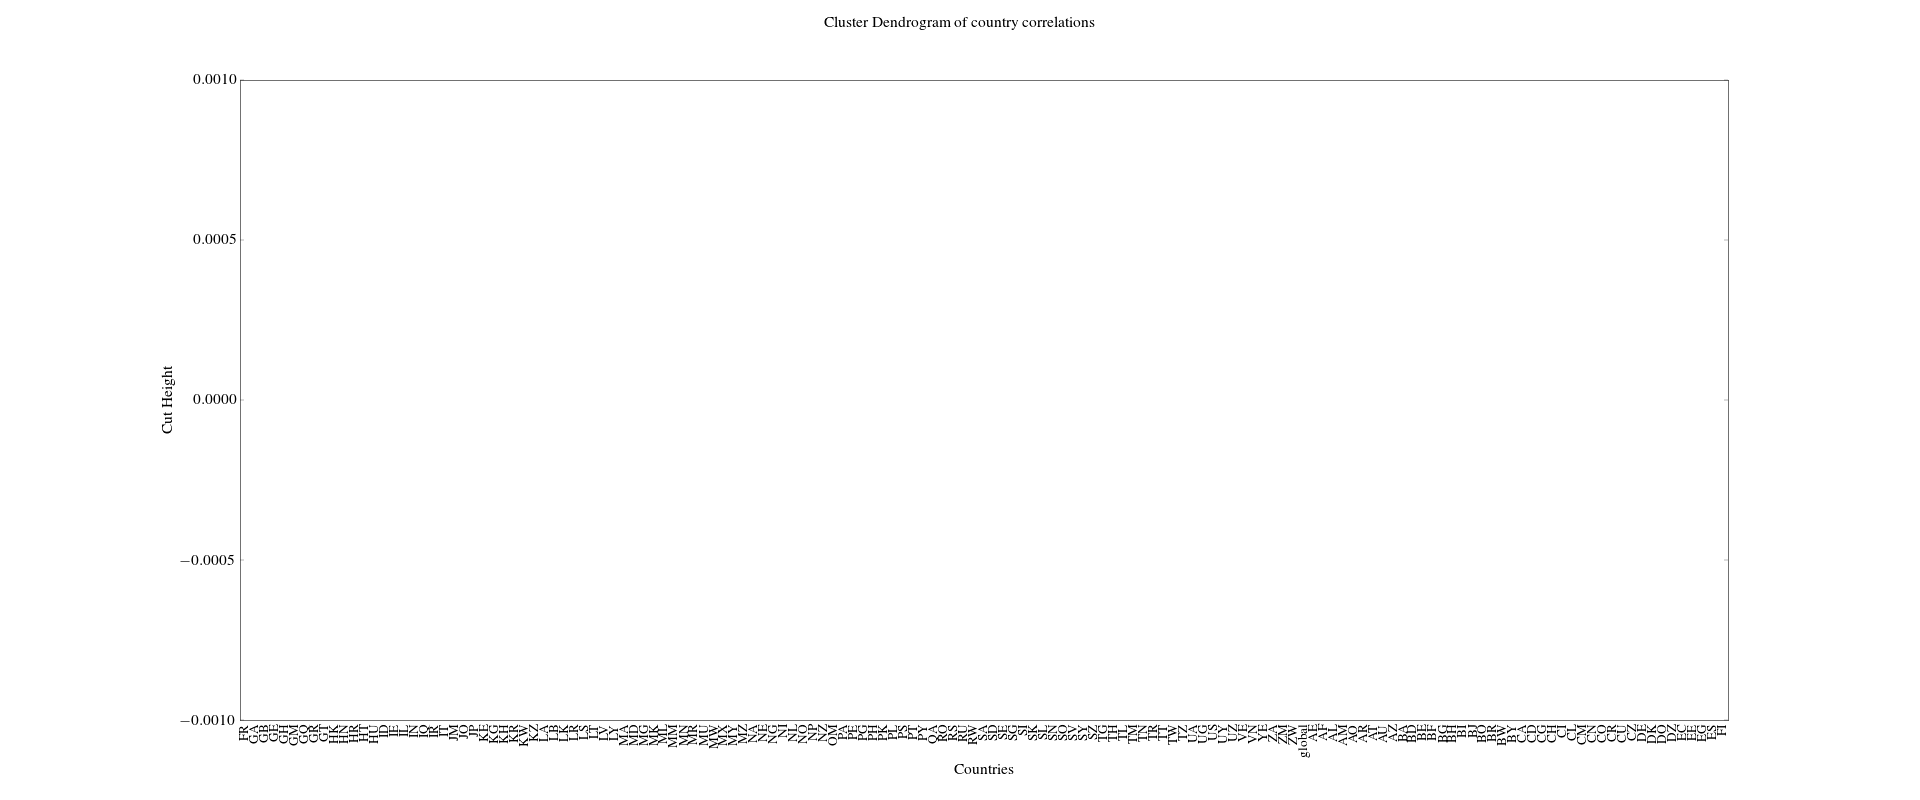

In [16]:
filter_agg = censor_country.reset_index()
temp = filter_agg[~filter_agg['sIP'].isin(bad_sIP_list) ].set_index('domain').fillna(0)
del temp['sIP'], temp['slash24'], temp['subcat']

corr_mat = temp.corr()

fig1, ax1 = plt.subplots(1,1, figsize=(24,10))

# single clusters together the closest countries first
Z=linkage(corr_mat, 'single')

R = dendrogram(Z)

ax1.set_xlabel('Countries')
ax1.set_ylabel('Cut Height')

labels = [item.get_text() for item in ax1.get_xticklabels()]
country_labels = [corr_mat.index[int(i)] for i in labels]

ax1.set_xticklabels(country_labels, fontsize = 12)
fig1.suptitle('Cluster Dendrogram of country correlations', fontweight='bold', fontsize=14);

fig1.savefig("hierarchical_clustering_country_correlation_filtered_bad_sIPs_agg")

<IPython.core.display.Javascript object>


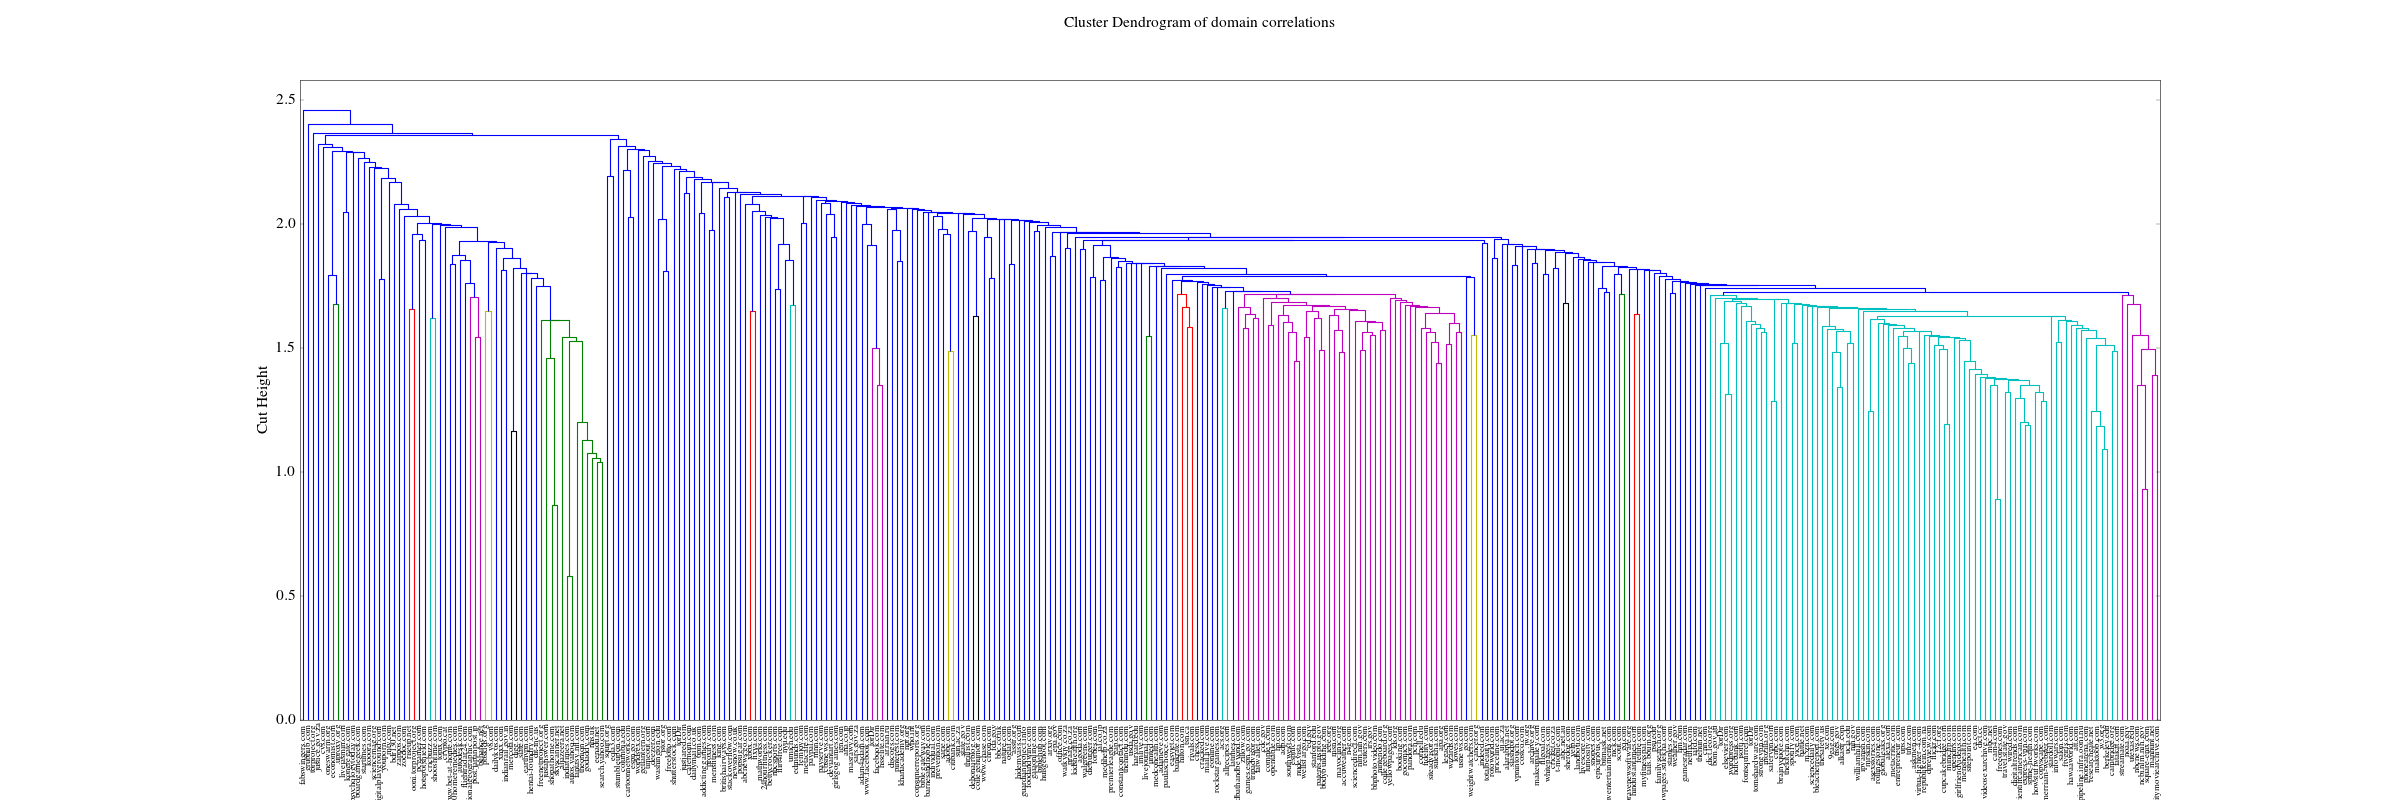

In [21]:
temp2 = temp.T

corr_mat = temp2.corr()

fig1, ax1 = plt.subplots(1,1, figsize=(30,10))

# single clusters together the closest countries first
Z=linkage(corr_mat, 'single')

R = dendrogram(Z)

ax1.set_xlabel('Countries')
ax1.set_ylabel('Cut Height')

labels = [item.get_text() for item in ax1.get_xticklabels()]
country_labels = [corr_mat.index[int(i)] for i in labels]

ax1.set_xticklabels(country_labels, fontsize = 8)
fig1.suptitle('Cluster Dendrogram of domain correlations', fontweight='bold', fontsize=14);

fig1.savefig("hierarchical_clustering_domain_correlation_filtered_bad_sIPs_agg")

In [29]:
df, c1, c2, c3, censor = get_raw_data(df_val, "171.67.215.200", "PL")

In [115]:
sIP = "204.74.99.100"
country = "US"
df, c1, c2, c3, censor = get_raw_data("204.74.99.100", "US")

In [31]:
df_cdns

,domain_x,sIP,total,global,us,us-tot,se,se-tot,jp,slash24,domain_y
0,aarp.org,204.74.99.100,770,0.772727,0.292453,106,0.962264,53,0.866667,204.74.99,2
1,expedia.com,204.74.99.101,665,0.616541,0.430233,86,0.956522,46,0.478873,204.74.99,2
2,ancestry.com,66.43.22.183,368,0.062500,0.000000,3,0.000000,4,0.000000,66.43.22,2
3,findagrave.com,66.43.22.135,368,0.046196,0.000000,1,0.000000,4,0.000000,66.43.22,2
4,answers.yahoo.com,216.115.110.118,691,0.053546,0.170732,41,0.122449,49,0.051282,216.115.110,2
5,tv.yahoo.com,216.115.110.119,725,0.051034,0.096774,31,0.115385,26,0.127660,216.115.110,2
6,ask.com,66.235.120.127,749,0.026702,0.000000,37,0.000000,20,0.086957,66.235.120,2
7,thesaurus.com,66.235.120.216,390,0.025641,0.333333,3,0.000000,3,0.000000,66.235.120,2
8,authoritynutrition.com,72.21.91.8,889,0.839145,0.960000,75,1.000000,57,0.750000,72.21.91,2
9,soundcloud.com,72.21.91.127,713,0.849930,0.860000,50,1.000000,36,0.822581,72.21.91,2
